# 비트코인 수익률 변동성 예측_LSTM

# 1**

X_train: (6534, 42, 3) Y_train: (6534, 1)
X_test: (554, 42, 3) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 3.3381e-04 - root_mean_squared_error: 0.0180 - val_loss: 2.8080e-04 - val_root_mean_squared_error: 0.0168
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 4.9513e-04 - root_mean_squared_error: 0.0213 - val_loss: 6.1439e-05 - val_root_mean_squared_error: 0.0078
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.9210e-04 - root_mean_squared_error: 0.0137 - val_loss: 9.0949e-05 - val_root_mean_squared_error: 0.0095
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 3.2825e-04 - root_mean_squared_error: 0.0178 - val_loss: 7.7264e-05 - val_root_mean_squared_error: 0.0088
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 1.6827e-04 - root_mean_squared_error: 0.0127 - val_loss: 3.1028e-05 - val_root_mean_squared_error: 0.0056
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 1.9476e-04 - root_mean_squared_error

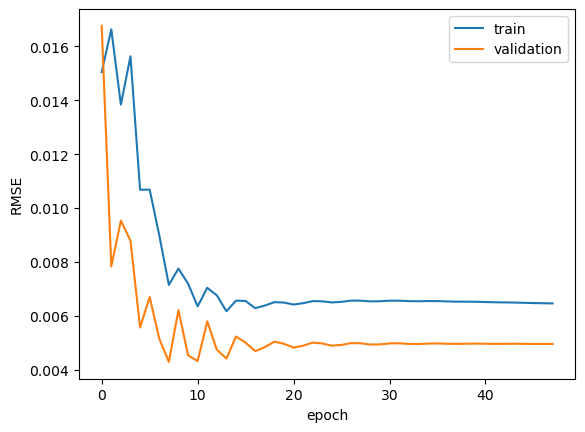

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step

RMSE: 0.00365

HMAE: 1.00543
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


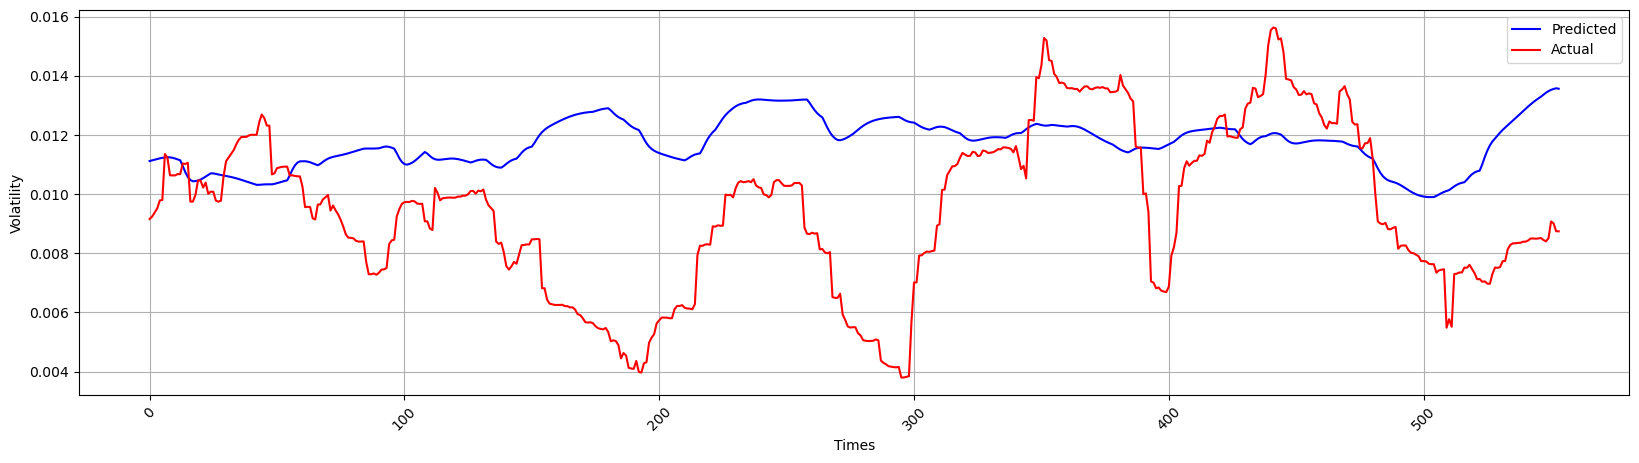

In [1]:
# 6/13 수정중
# HMAE 코드 수정
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import random

# 데이터셋 준비
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# 경제지표 모두 추가
X_garch = df[['KOSPI200_vol', 'CBOE_VIX_vol', 'USD_KRW_vol']].values 

# # 경제지표 다 뺌
# X_garch = df[['garch_vol', 'predicted_volatility']].values 

# #USD_KRW_vol만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol']].values 

# #'CBOE_VIX_vol'만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol']].values 

# #KOSPI200_vol만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','KOSPI200_vol']].values

# #USD + CBOE 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','CBOE_VIX_vol']].values 

# #USD + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','KOSPI200_vol']].values 

# #CEOB + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol','KOSPI200_vol']].values 

y = df['historical_volatility'].values

def dataset_split(x_set, y_set):
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')
    train_x = x_set[:train_end + 1]
    train_y = y_set[:train_end + 1]
    valid_x = x_set[train_end + 1:valid_end + 1]
    valid_y = y_set[train_end + 1:valid_end + 1]
    test_x = x_set[valid_end + 1:]
    test_y = y_set[valid_end + 1:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler_x.fit_transform(train_X_garch)
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch = Y_train
valid_y_garch = Y_valid
test_y_garch = Y_test

train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)


# HMAE 계산 함수
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(tf.cast(y_true - y_pred, tf.float32), axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance + tf.keras.backend.epsilon()))
        return hmae

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)

def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                    epochs=100,
                    validation_data=(valid_X_garch, valid_y_garch),
                    batch_size=512,
                    callbacks=[stop_early],
                    shuffle=False)


def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    #plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nRMSE: {rmse:.5f}")

    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
    print(f"\nHMAE: {hmae_value.numpy():.5f}")

model_RMSE_plot(history, "LSTM_vol")
printing_out_results_of_a_model(model, test_X_garch, test_y_garch)

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])
    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]
    result_df.to_excel('LSTM_NEW11.xlsx', index=False)
    return result_df

result_df = result_to_excel(model, test_X_garch, test_y_garch)
plt.figure(figsize=(20, 5))
plt.plot(result_df['Prediction_y'], linestyle='-', color='blue', label='Predicted')
plt.plot(result_df['Actual_y'], linestyle='-', color='red', label='Actual')
plt.xlabel('Times')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# 1

X_train: (6534, 42, 4) Y_train: (6534, 1)
X_test: (554, 42, 4) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 3.3410e-04 - root_mean_squared_error: 0.0180 - val_loss: 2.8036e-04 - val_root_mean_squared_error: 0.0167
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 4.9436e-04 - root_mean_squared_error: 0.0213 - val_loss: 6.1028e-05 - val_root_mean_squared_error: 0.0078
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 1.9137e-04 - root_mean_squared_error: 0.0137 - val_loss: 9.0950e-05 - val_root_mean_squared_error: 0.0095
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 3.2698e-04 - root_mean_squared_error: 0.0178 - val_loss: 7.6956e-05 - val_root_mean_squared_error: 0.0088
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 1.6639e-04 - root_mean_squared_error: 0.0127 - val_loss: 3.0721e-05 - val_root_mean_squared_error: 0.0055
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 1.9359e-04 - root_mean_squared_error

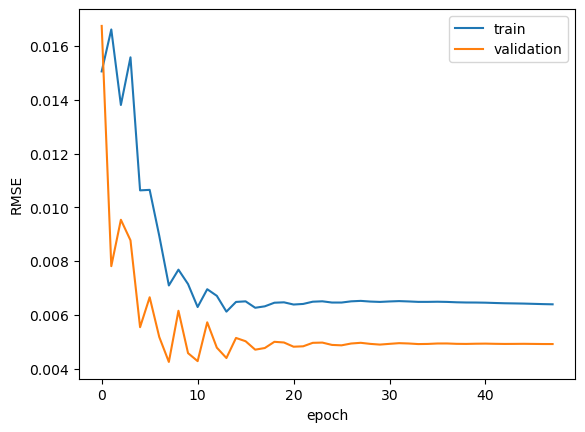

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step

RMSE: 0.00360

HMAE: 1.00520
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


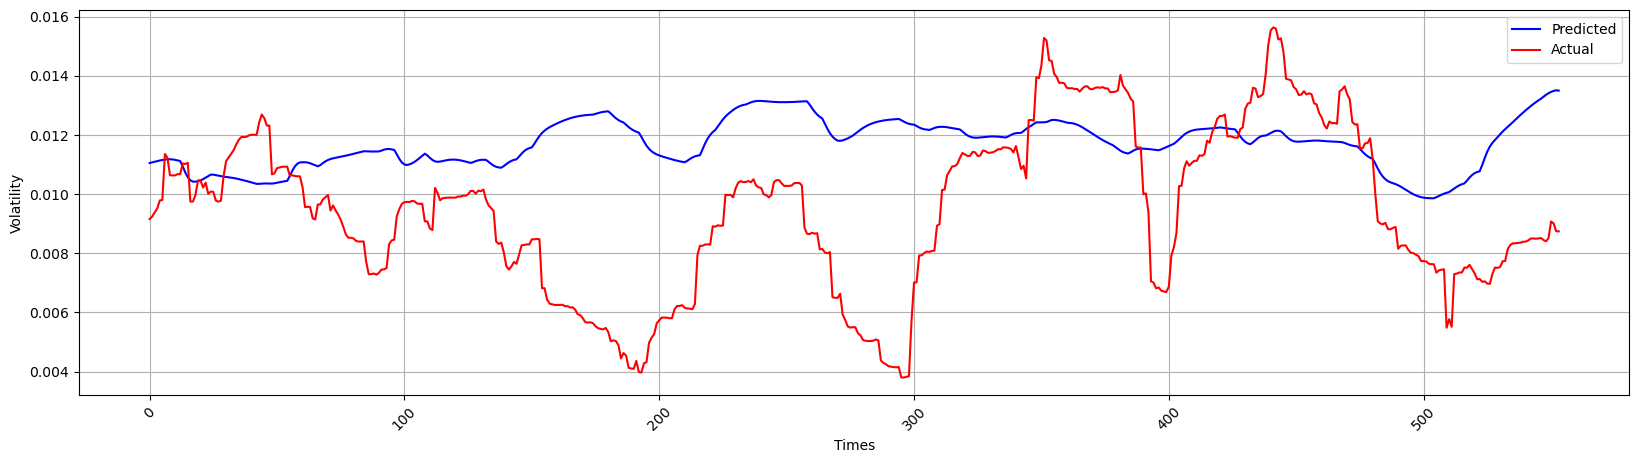

In [2]:
# 6/13 수정중
# HMAE 코드 수정
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import random

# 데이터셋 준비
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# 경제지표 모두 추가
X_garch = df[['KOSPI200_vol', 'CBOE_VIX_vol', 'USD_KRW_vol', 'predicted_volatility']].values 

# # 경제지표 다 뺌
# X_garch = df[['garch_vol', 'predicted_volatility']].values 

# #USD_KRW_vol만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol']].values 

# #'CBOE_VIX_vol'만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol']].values 

# #KOSPI200_vol만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','KOSPI200_vol']].values

# #USD + CBOE 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','CBOE_VIX_vol']].values 

# #USD + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','KOSPI200_vol']].values 

# #CEOB + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol','KOSPI200_vol']].values 

y = df['historical_volatility'].values

def dataset_split(x_set, y_set):
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')
    train_x = x_set[:train_end + 1]
    train_y = y_set[:train_end + 1]
    valid_x = x_set[train_end + 1:valid_end + 1]
    valid_y = y_set[train_end + 1:valid_end + 1]
    test_x = x_set[valid_end + 1:]
    test_y = y_set[valid_end + 1:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler_x.fit_transform(train_X_garch)
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch = Y_train
valid_y_garch = Y_valid
test_y_garch = Y_test

train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)


# HMAE 계산 함수
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(tf.cast(y_true - y_pred, tf.float32), axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance + tf.keras.backend.epsilon()))
        return hmae

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)

def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                    epochs=100,
                    validation_data=(valid_X_garch, valid_y_garch),
                    batch_size=512,
                    callbacks=[stop_early],
                    shuffle=False)


def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    #plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nRMSE: {rmse:.5f}")

    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
    print(f"\nHMAE: {hmae_value.numpy():.5f}")

model_RMSE_plot(history, "LSTM_vol")
printing_out_results_of_a_model(model, test_X_garch, test_y_garch)

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])
    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]
    result_df.to_excel('LSTM_NEW1.xlsx', index=False)
    return result_df

result_df = result_to_excel(model, test_X_garch, test_y_garch)
plt.figure(figsize=(20, 5))
plt.plot(result_df['Prediction_y'], linestyle='-', color='blue', label='Predicted')
plt.plot(result_df['Actual_y'], linestyle='-', color='red', label='Actual')
plt.xlabel('Times')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# 2

X_train: (6534, 42, 1) Y_train: (6534, 1)
X_test: (554, 42, 1) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 1.0413e-04 - root_mean_squared_error: 0.0099 - val_loss: 1.4874e-05 - val_root_mean_squared_error: 0.0039
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 7.5420e-05 - root_mean_squared_error: 0.0086 - val_loss: 5.9009e-05 - val_root_mean_squared_error: 0.0077
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 5.3907e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.5205e-05 - val_root_mean_squared_error: 0.0050
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 5.4553e-05 - root_mean_squared_error: 0.0073 - val_loss: 4.1341e-05 - val_root_mean_squared_error: 0.0064
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 5.1312e-05 - root_mean_squared_error: 0.0071 - val_loss: 3.1837e-05 - val_root_mean_squared_error: 0.0056
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 5.1722e-05 - root_mean_squared_error

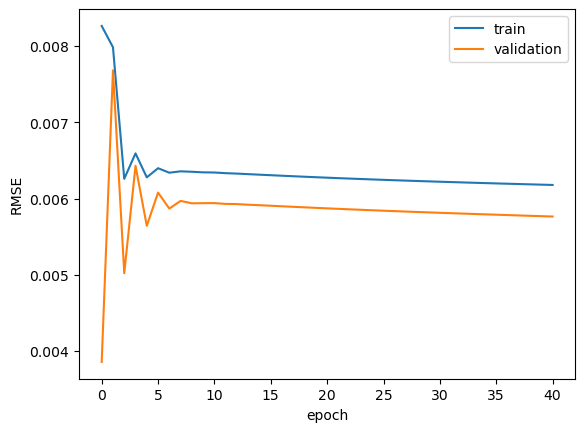

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step

RMSE: 0.00378

HMAE: 1.19507
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


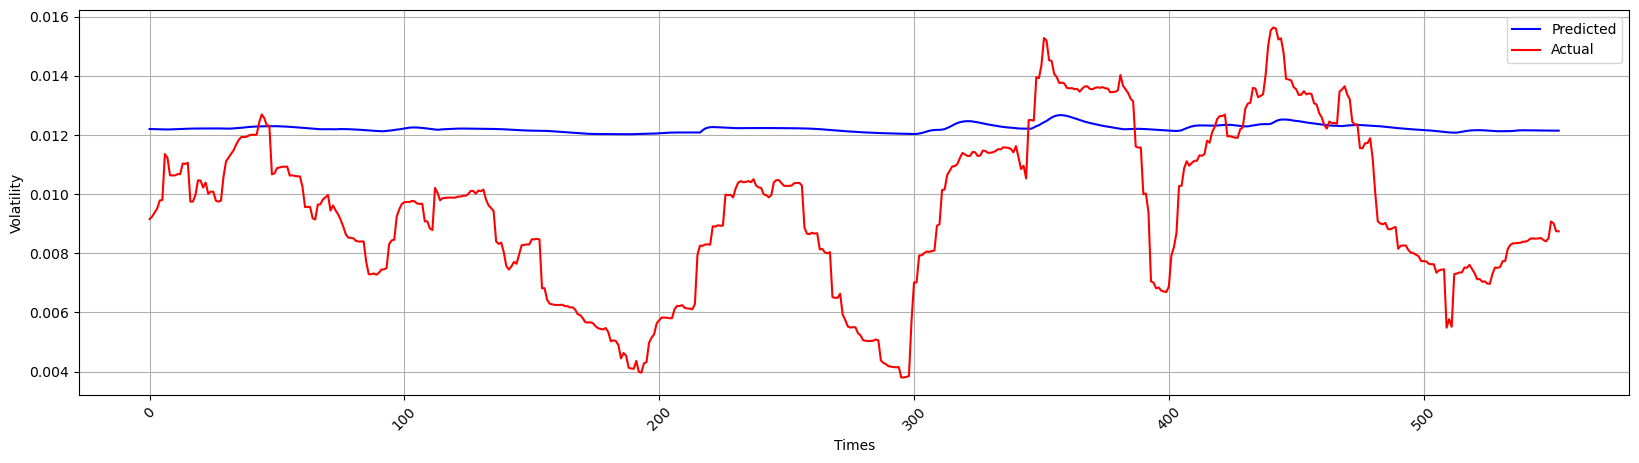

In [3]:
# 6/13 수정중
# HMAE 코드 수정
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import random

# 데이터셋 준비
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# # 경제지표 모두 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','KOSPI200_vol','CBOE_VIX_vol','USD_KRW_vol']].values 

# 경제지표 다 뺌
X_garch = df[['predicted_volatility']].values 

# #USD_KRW_vol만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol']].values 

# #'CBOE_VIX_vol'만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol']].values 

# #KOSPI200_vol만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','KOSPI200_vol']].values

# #USD + CBOE 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','CBOE_VIX_vol']].values 

# #USD + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','KOSPI200_vol']].values 

# #CEOB + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol','KOSPI200_vol']].values 

y = df['historical_volatility'].values

def dataset_split(x_set, y_set):
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')
    train_x = x_set[:train_end + 1]
    train_y = y_set[:train_end + 1]
    valid_x = x_set[train_end + 1:valid_end + 1]
    valid_y = y_set[train_end + 1:valid_end + 1]
    test_x = x_set[valid_end + 1:]
    test_y = y_set[valid_end + 1:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler_x.fit_transform(train_X_garch)
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch = Y_train
valid_y_garch = Y_valid
test_y_garch = Y_test

train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)


# HMAE 계산 함수
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(tf.cast(y_true - y_pred, tf.float32), axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance + tf.keras.backend.epsilon()))
        return hmae

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)

def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                    epochs=100,
                    validation_data=(valid_X_garch, valid_y_garch),
                    batch_size=512,
                    callbacks=[stop_early],
                    shuffle=False)


def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    #plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nRMSE: {rmse:.5f}")

    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
    print(f"\nHMAE: {hmae_value.numpy():.5f}")

model_RMSE_plot(history, "LSTM_vol")
printing_out_results_of_a_model(model, test_X_garch, test_y_garch)

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])
    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]
    result_df.to_excel('LSTM_NEW2.xlsx', index=False)
    return result_df

result_df = result_to_excel(model, test_X_garch, test_y_garch)
plt.figure(figsize=(20, 5))
plt.plot(result_df['Prediction_y'], linestyle='-', color='blue', label='Predicted')
plt.plot(result_df['Actual_y'], linestyle='-', color='red', label='Actual')
plt.xlabel('Times')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# 3

X_train: (6534, 42, 2) Y_train: (6534, 1)
X_test: (554, 42, 2) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 1.5256e-04 - root_mean_squared_error: 0.0123 - val_loss: 8.4458e-05 - val_root_mean_squared_error: 0.0092
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 1.7249e-04 - root_mean_squared_error: 0.0129 - val_loss: 2.4318e-05 - val_root_mean_squared_error: 0.0049
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 1.8494e-04 - root_mean_squared_error: 0.0135 - val_loss: 8.2596e-05 - val_root_mean_squared_error: 0.0091
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 7.2379e-05 - root_mean_squared_error: 0.0084 - val_loss: 6.8018e-05 - val_root_mean_squared_error: 0.0082
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 8.9343e-05 - root_mean_squared_error: 0.0094 - val_loss: 1.2857e-05 - val_root_mean_squared_error: 0.0036
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 7.6582e-05 - root_mean_squared_error

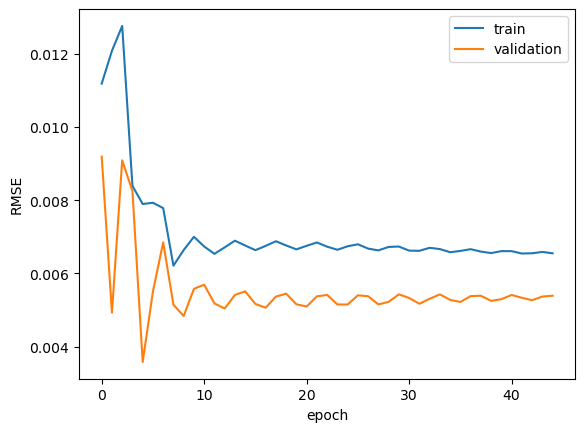

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step

RMSE: 0.00373

HMAE: 1.14387
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


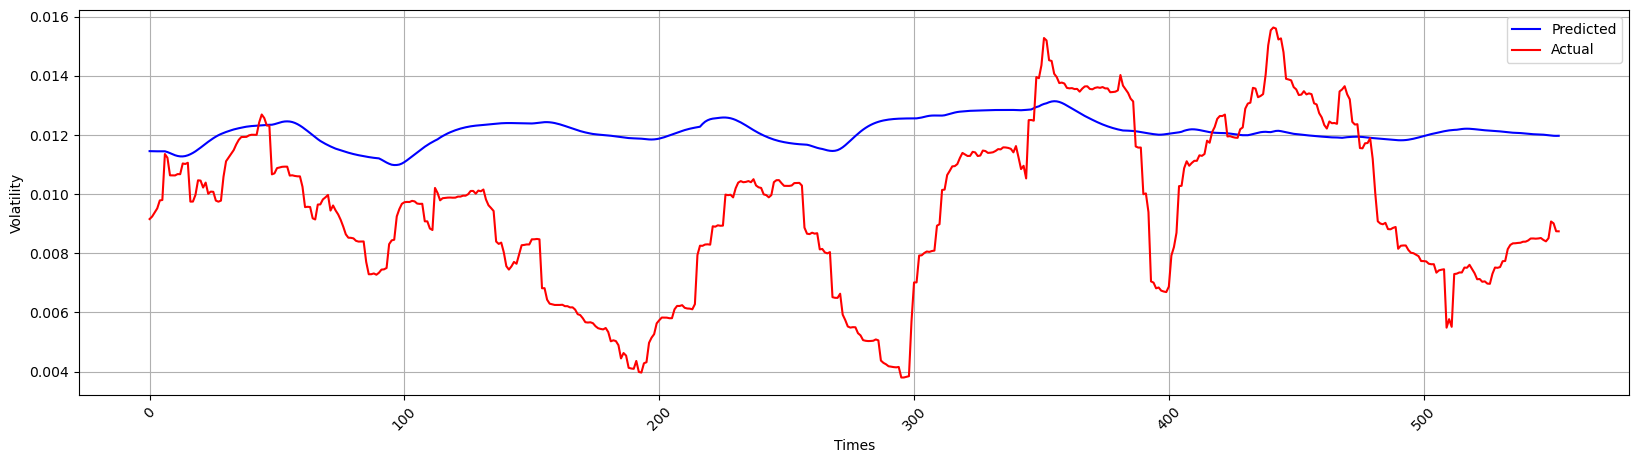

In [4]:
# 6/13 수정중
# HMAE 코드 수정
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import random

# 데이터셋 준비
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# # 경제지표 모두 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','KOSPI200_vol','CBOE_VIX_vol','USD_KRW_vol']].values 

# # 경제지표 다 뺌
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility']].values 

#USD_KRW_vol만 추가
X_garch = df[['USD_KRW_vol', 'predicted_volatility']].values 

# #'CBOE_VIX_vol'만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol']].values 

# #KOSPI200_vol만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','KOSPI200_vol']].values

# #USD + CBOE 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','CBOE_VIX_vol']].values 

# #USD + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','KOSPI200_vol']].values 

# #CEOB + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol','KOSPI200_vol']].values 

y = df['historical_volatility'].values

def dataset_split(x_set, y_set):
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')
    train_x = x_set[:train_end + 1]
    train_y = y_set[:train_end + 1]
    valid_x = x_set[train_end + 1:valid_end + 1]
    valid_y = y_set[train_end + 1:valid_end + 1]
    test_x = x_set[valid_end + 1:]
    test_y = y_set[valid_end + 1:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler_x.fit_transform(train_X_garch)
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch = Y_train
valid_y_garch = Y_valid
test_y_garch = Y_test

train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)


# HMAE 계산 함수
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(tf.cast(y_true - y_pred, tf.float32), axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance + tf.keras.backend.epsilon()))
        return hmae

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)

def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                    epochs=100,
                    validation_data=(valid_X_garch, valid_y_garch),
                    batch_size=512,
                    callbacks=[stop_early],
                    shuffle=False)


def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    #plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nRMSE: {rmse:.5f}")

    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
    print(f"\nHMAE: {hmae_value.numpy():.5f}")

model_RMSE_plot(history, "LSTM_vol")
printing_out_results_of_a_model(model, test_X_garch, test_y_garch)

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])
    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]
    result_df.to_excel('LSTM_NEW3.xlsx', index=False)
    return result_df

result_df = result_to_excel(model, test_X_garch, test_y_garch)
plt.figure(figsize=(20, 5))
plt.plot(result_df['Prediction_y'], linestyle='-', color='blue', label='Predicted')
plt.plot(result_df['Actual_y'], linestyle='-', color='red', label='Actual')
plt.xlabel('Times')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# 4

X_train: (6534, 42, 2) Y_train: (6534, 1)
X_test: (554, 42, 2) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 1.7775e-04 - root_mean_squared_error: 0.0131 - val_loss: 2.6992e-05 - val_root_mean_squared_error: 0.0052
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 1.8978e-04 - root_mean_squared_error: 0.0133 - val_loss: 4.7978e-05 - val_root_mean_squared_error: 0.0069
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 2.0431e-04 - root_mean_squared_error: 0.0138 - val_loss: 1.3215e-05 - val_root_mean_squared_error: 0.0036
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 9.9406e-05 - root_mean_squared_error: 0.0099 - val_loss: 3.2928e-05 - val_root_mean_squared_error: 0.0057
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 6.7744e-05 - root_mean_squared_error: 0.0082 - val_loss: 4.2598e-05 - val_root_mean_squared_error: 0.0065
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 5.5220e-05 - root_mean_squared_error

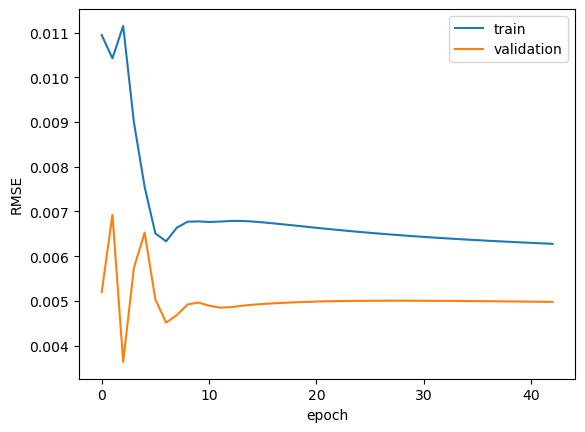

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step

RMSE: 0.00314

HMAE: 0.93405
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


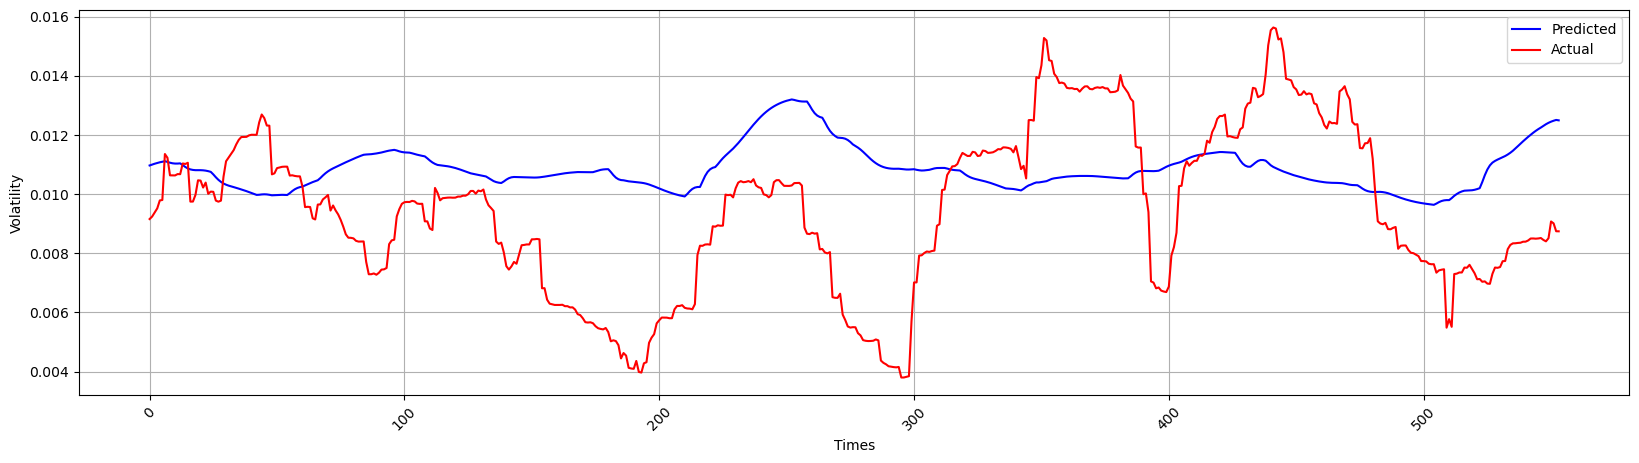

In [5]:
# 6/13 수정중
# HMAE 코드 수정
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import random

# 데이터셋 준비
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# # 경제지표 모두 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','KOSPI200_vol','CBOE_VIX_vol','USD_KRW_vol']].values 

# # 경제지표 다 뺌
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility']].values 

# #USD_KRW_vol만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','USD_KRW_vol']].values 

#'CBOE_VIX_vol'만 추가
X_garch = df[['predicted_volatility', 'CBOE_VIX_vol']].values 

# #KOSPI200_vol만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','KOSPI200_vol']].values

# #USD + CBOE 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','CBOE_VIX_vol']].values 

# #USD + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','KOSPI200_vol']].values 

# #CEOB + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol','KOSPI200_vol']].values 

y = df['historical_volatility'].values

def dataset_split(x_set, y_set):
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')
    train_x = x_set[:train_end + 1]
    train_y = y_set[:train_end + 1]
    valid_x = x_set[train_end + 1:valid_end + 1]
    valid_y = y_set[train_end + 1:valid_end + 1]
    test_x = x_set[valid_end + 1:]
    test_y = y_set[valid_end + 1:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler_x.fit_transform(train_X_garch)
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch = Y_train
valid_y_garch = Y_valid
test_y_garch = Y_test

train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)


# HMAE 계산 함수
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(tf.cast(y_true - y_pred, tf.float32), axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance + tf.keras.backend.epsilon()))
        return hmae

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)

def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                    epochs=100,
                    validation_data=(valid_X_garch, valid_y_garch),
                    batch_size=512,
                    callbacks=[stop_early],
                    shuffle=False)


def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    #plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nRMSE: {rmse:.5f}")

    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
    print(f"\nHMAE: {hmae_value.numpy():.5f}")

model_RMSE_plot(history, "LSTM_vol")
printing_out_results_of_a_model(model, test_X_garch, test_y_garch)

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])
    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]
    result_df.to_excel('LSTM_NEW4.xlsx', index=False)
    return result_df

result_df = result_to_excel(model, test_X_garch, test_y_garch)
plt.figure(figsize=(20, 5))
plt.plot(result_df['Prediction_y'], linestyle='-', color='blue', label='Predicted')
plt.plot(result_df['Actual_y'], linestyle='-', color='red', label='Actual')
plt.xlabel('Times')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# 5

X_train: (6534, 42, 2) Y_train: (6534, 1)
X_test: (554, 42, 2) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 6.5731e-05 - root_mean_squared_error: 0.0081 - val_loss: 3.5412e-05 - val_root_mean_squared_error: 0.0060
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 1.3082e-04 - root_mean_squared_error: 0.0111 - val_loss: 2.3251e-05 - val_root_mean_squared_error: 0.0048
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 1.7495e-04 - root_mean_squared_error: 0.0131 - val_loss: 1.2804e-04 - val_root_mean_squared_error: 0.0113
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 2.4612e-04 - root_mean_squared_error: 0.0153 - val_loss: 2.4898e-05 - val_root_mean_squared_error: 0.0050
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 9.9563e-05 - root_mean_squared_error: 0.0098 - val_loss: 4.9714e-05 - val_root_mean_squared_error: 0.0071
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 6.1523e-05 - root_mean_squared_error

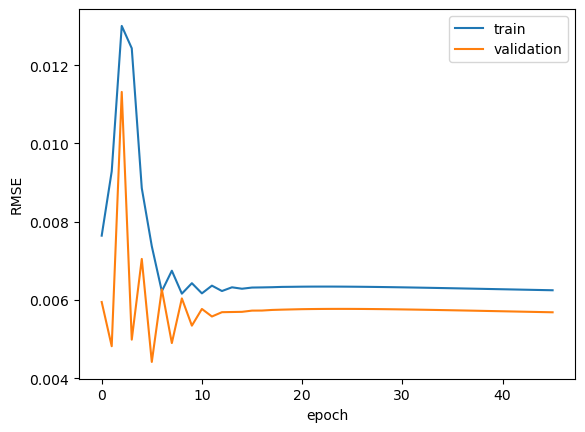

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step

RMSE: 0.00405

HMAE: 1.14632
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


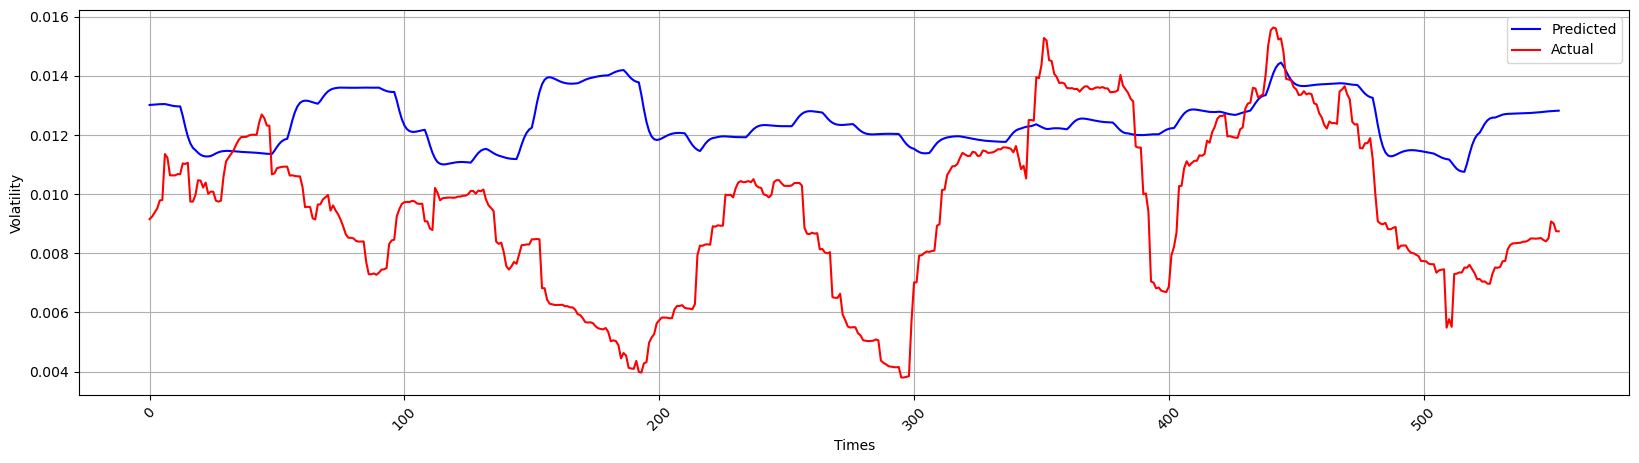

In [6]:
# 6/13 수정중
# HMAE 코드 수정
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import random

# 데이터셋 준비
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# # 경제지표 모두 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','KOSPI200_vol','CBOE_VIX_vol','USD_KRW_vol']].values 

# # 경제지표 다 뺌
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility']].values 

# #USD_KRW_vol만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','USD_KRW_vol']].values 

# #'CBOE_VIX_vol'만 추가
# X_garch = df[['predicted_volatility', 'CBOE_VIX_vol']].values 

#KOSPI200_vol만 추가
X_garch = df[['predicted_volatility','KOSPI200_vol']].values

# #USD + CBOE 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','CBOE_VIX_vol']].values 

# #USD + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','KOSPI200_vol']].values 

# #CEOB + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol','KOSPI200_vol']].values 

y = df['historical_volatility'].values

def dataset_split(x_set, y_set):
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')
    train_x = x_set[:train_end + 1]
    train_y = y_set[:train_end + 1]
    valid_x = x_set[train_end + 1:valid_end + 1]
    valid_y = y_set[train_end + 1:valid_end + 1]
    test_x = x_set[valid_end + 1:]
    test_y = y_set[valid_end + 1:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler_x.fit_transform(train_X_garch)
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch = Y_train
valid_y_garch = Y_valid
test_y_garch = Y_test

train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)


# HMAE 계산 함수
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(tf.cast(y_true - y_pred, tf.float32), axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance + tf.keras.backend.epsilon()))
        return hmae

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)

def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                    epochs=100,
                    validation_data=(valid_X_garch, valid_y_garch),
                    batch_size=512,
                    callbacks=[stop_early],
                    shuffle=False)


def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    #plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nRMSE: {rmse:.5f}")

    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
    print(f"\nHMAE: {hmae_value.numpy():.5f}")

model_RMSE_plot(history, "LSTM_vol")
printing_out_results_of_a_model(model, test_X_garch, test_y_garch)

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])
    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]
    result_df.to_excel('LSTM_NEW5.xlsx', index=False)
    return result_df

result_df = result_to_excel(model, test_X_garch, test_y_garch)
plt.figure(figsize=(20, 5))
plt.plot(result_df['Prediction_y'], linestyle='-', color='blue', label='Predicted')
plt.plot(result_df['Actual_y'], linestyle='-', color='red', label='Actual')
plt.xlabel('Times')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# EDIT11

X_train: (6534, 42, 3) Y_train: (6534, 1)
X_test: (554, 42, 3) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 4.6934e-04 - root_mean_squared_error: 0.0214 - val_loss: 1.8627e-04 - val_root_mean_squared_error: 0.0136
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 4.8137e-04 - root_mean_squared_error: 0.0211 - val_loss: 3.2418e-05 - val_root_mean_squared_error: 0.0057
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 1.8200e-04 - root_mean_squared_error: 0.0135 - val_loss: 4.2218e-05 - val_root_mean_squared_error: 0.0065
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 2.2390e-04 - root_mean_squared_error: 0.0149 - val_loss: 9.8214e-05 - val_root_mean_squared_error: 0.0099
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.3897e-04 - root_mean_squared_error: 0.0115 - val_loss: 1.9466e-05 - val_root_mean_squared_error: 0.0044
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 9.8295e-05 - root_mean_squared_error

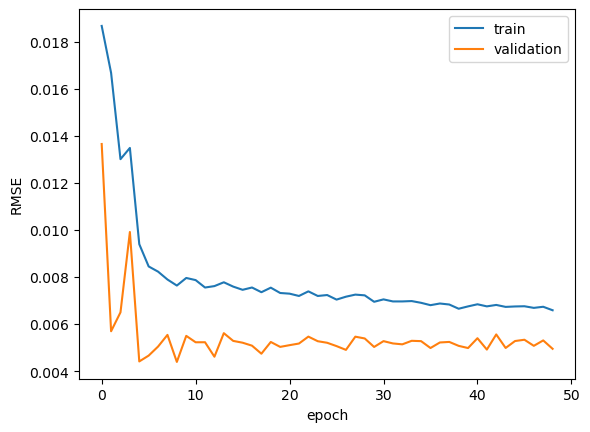

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step

RMSE: 0.00338

HMAE: 0.99120
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


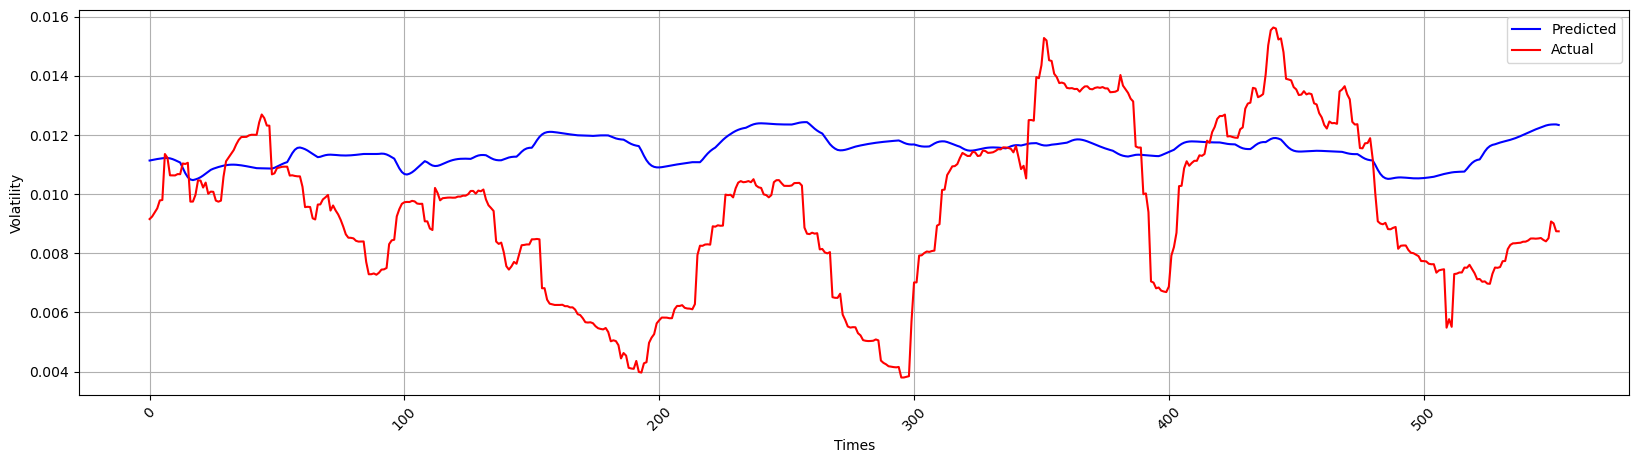

In [10]:
# 6/13 수정중
# HMAE 코드 수정
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import random

# 데이터셋 준비
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# 경제지표 모두 추가
X_garch = df[['KOSPI200_vol','CBOE_VIX_vol','USD_KRW_vol']].values 

# # 경제지표 다 뺌
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility']].values 

# #USD_KRW_vol만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','USD_KRW_vol']].values 

# #'CBOE_VIX_vol'만 추가
# X_garch = df[['predicted_volatility', 'CBOE_VIX_vol']].values 

# #KOSPI200_vol만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','KOSPI200_vol']].values

# #USD + CBOE 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','CBOE_VIX_vol']].values 

# #USD + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','KOSPI200_vol']].values 

# #CEOB + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol','KOSPI200_vol']].values 

y = df['historical_volatility'].values

def dataset_split(x_set, y_set):
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')
    train_x = x_set[:train_end + 1]
    train_y = y_set[:train_end + 1]
    valid_x = x_set[train_end + 1:valid_end + 1]
    valid_y = y_set[train_end + 1:valid_end + 1]
    test_x = x_set[valid_end + 1:]
    test_y = y_set[valid_end + 1:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler_x.fit_transform(train_X_garch)
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch = Y_train
valid_y_garch = Y_valid
test_y_garch = Y_test

train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)


# HMAE 계산 함수
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(tf.cast(y_true - y_pred, tf.float32), axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance + tf.keras.backend.epsilon()))
        return hmae

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)

# def build_model():
#     inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
#     y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
#     y = tf.keras.layers.LSTM(units=500)(y)
#     y = tf.keras.layers.Dense(1)(y)

#     model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

#     model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
#                   loss=tf.keras.losses.MeanSquaredError(),
#                   metrics=[tf.keras.metrics.RootMeanSquaredError()])
#     return model

def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    
    # LSTM 레이어에 dropout 추가
    y = tf.keras.layers.LSTM(units=500, return_sequences=True, dropout=0.2)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500, dropout=0.2)(y)
    
    # 또는 Dropout 레이어를 명시적으로 추가
    # y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    # y = tf.keras.layers.Dropout(0.2)(y)
    # y = tf.keras.layers.LSTM(units=500)(y)
    # y = tf.keras.layers.Dropout(0.2)(y)

    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                    epochs=100,
                    validation_data=(valid_X_garch, valid_y_garch),
                    batch_size=512,
                    callbacks=[stop_early],
                    shuffle=False)


def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    #plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nRMSE: {rmse:.5f}")

    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
    print(f"\nHMAE: {hmae_value.numpy():.5f}")

model_RMSE_plot(history, "LSTM_vol")
printing_out_results_of_a_model(model, test_X_garch, test_y_garch)

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])
    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]
    result_df.to_excel('LSTM_NEW_Edit_11.xlsx', index=False)
    return result_df

result_df = result_to_excel(model, test_X_garch, test_y_garch)
plt.figure(figsize=(20, 5))
plt.plot(result_df['Prediction_y'], linestyle='-', color='blue', label='Predicted')
plt.plot(result_df['Actual_y'], linestyle='-', color='red', label='Actual')
plt.xlabel('Times')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# EDIT11_2

X_train: (6534, 42, 3) Y_train: (6534, 1)
X_test: (554, 42, 3) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 346ms/step - loss: 6.3291e-04 - root_mean_squared_error: 0.0245 - val_loss: 7.5780e-05 - val_root_mean_squared_error: 0.0087
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 315ms/step - loss: 4.6927e-04 - root_mean_squared_error: 0.0216 - val_loss: 1.2345e-04 - val_root_mean_squared_error: 0.0111
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 334ms/step - loss: 4.6610e-04 - root_mean_squared_error: 0.0210 - val_loss: 3.7546e-05 - val_root_mean_squared_error: 0.0061
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 354ms/step - loss: 1.5853e-04 - root_mean_squared_error: 0.0125 - val_loss: 5.1948e-05 - val_root_mean_squared_error: 0.0072
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 369ms/step - loss: 1.8965e-04 - root_mean_squared_error: 0.0137 - val_loss: 2.8379e-05 - val_root_mean_squared_error: 0.0053
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 385ms/step - loss: 1.3065e-04 - root_mean_s

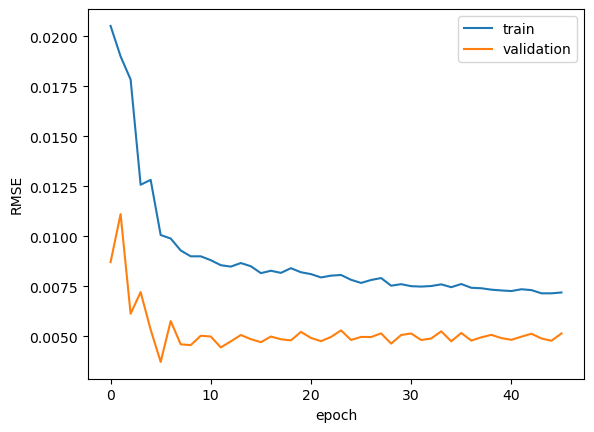

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step

RMSE: 0.00371

HMAE: 1.01108
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


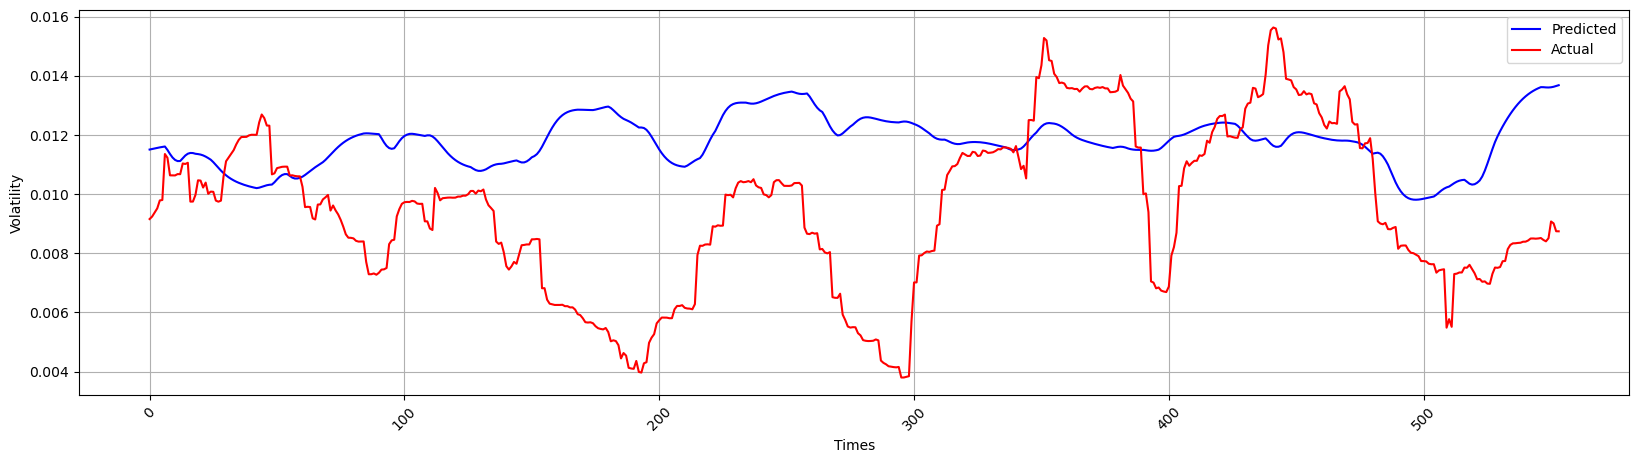

In [14]:
# 6/13 수정중
# HMAE 코드 수정
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import random

# 데이터셋 준비
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# 경제지표 모두 추가
X_garch = df[['KOSPI200_vol','CBOE_VIX_vol','USD_KRW_vol']].values 

# # 경제지표 다 뺌
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility']].values 

# #USD_KRW_vol만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','USD_KRW_vol']].values 

# #'CBOE_VIX_vol'만 추가
# X_garch = df[['predicted_volatility', 'CBOE_VIX_vol']].values 

# #KOSPI200_vol만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','KOSPI200_vol']].values

# #USD + CBOE 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','CBOE_VIX_vol']].values 

# #USD + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','KOSPI200_vol']].values 

# #CEOB + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol','KOSPI200_vol']].values 

y = df['historical_volatility'].values

def dataset_split(x_set, y_set):
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')
    train_x = x_set[:train_end + 1]
    train_y = y_set[:train_end + 1]
    valid_x = x_set[train_end + 1:valid_end + 1]
    valid_y = y_set[train_end + 1:valid_end + 1]
    test_x = x_set[valid_end + 1:]
    test_y = y_set[valid_end + 1:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler_x.fit_transform(train_X_garch)
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch = Y_train
valid_y_garch = Y_valid
test_y_garch = Y_test

train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)


# HMAE 계산 함수
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(tf.cast(y_true - y_pred, tf.float32), axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance + tf.keras.backend.epsilon()))
        return hmae

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)

# def build_model():
#     inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
#     y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
#     y = tf.keras.layers.LSTM(units=500)(y)
#     y = tf.keras.layers.Dense(1)(y)

#     model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

#     model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
#                   loss=tf.keras.losses.MeanSquaredError(),
#                   metrics=[tf.keras.metrics.RootMeanSquaredError()])
#     return model

def build_model():

    inputLSTM_GARCH_EGARCH = Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    x = LSTM(units=200, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    x = Dropout(0.2)(x)
    x = LSTM(units=200)(x)
    x = Dropout(0.2)(x)
    # x = LSTM(units=100)(x)
    x = Dense(1)(x)
    
    model = Model(inputs=inputLSTM_GARCH_EGARCH, outputs=x)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='mean_squared_error',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                    epochs=100,
                    validation_data=(valid_X_garch, valid_y_garch),
                    batch_size=512,
                    callbacks=[stop_early],
                    shuffle=False)


def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    #plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nRMSE: {rmse:.5f}")

    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
    print(f"\nHMAE: {hmae_value.numpy():.5f}")

model_RMSE_plot(history, "LSTM_vol")
printing_out_results_of_a_model(model, test_X_garch, test_y_garch)

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])
    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]
    result_df.to_excel('LSTM_NEW_Edit_11_2.xlsx', index=False)
    return result_df

result_df = result_to_excel(model, test_X_garch, test_y_garch)
plt.figure(figsize=(20, 5))
plt.plot(result_df['Prediction_y'], linestyle='-', color='blue', label='Predicted')
plt.plot(result_df['Actual_y'], linestyle='-', color='red', label='Actual')
plt.xlabel('Times')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# EDIT_11_3

X_train: (6534, 42, 3) Y_train: (6534, 1)
X_test: (554, 42, 3) Y_test: (554, 1)
Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - loss: 2.6728e-04 - root_mean_squared_error: 0.0161 - val_loss: 2.2647e-05 - val_root_mean_squared_error: 0.0048
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 303ms/step - loss: 1.4387e-04 - root_mean_squared_error: 0.0118 - val_loss: 3.2783e-05 - val_root_mean_squared_error: 0.0057
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 225ms/step - loss: 1.2106e-04 - root_mean_squared_error: 0.0109 - val_loss: 5.3941e-05 - val_root_mean_squared_error: 0.0073
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - loss: 1.2834e-04 - root_mean_squared_error: 0.0112 - val_loss: 6.0084e-05 - val_root_mean_squared_error: 0.0078
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - loss: 1.4400e-04 - root_mean_squared_error: 0.0119 - val_loss: 5.2000e-05 - val_root_mean_squared_error: 0.0072
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - loss: 1.1959e-04 - root_mea

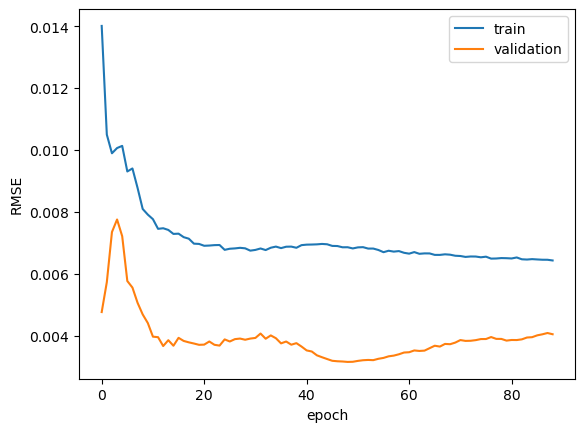

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

RMSE: 0.00314

HMAE: 0.84394
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


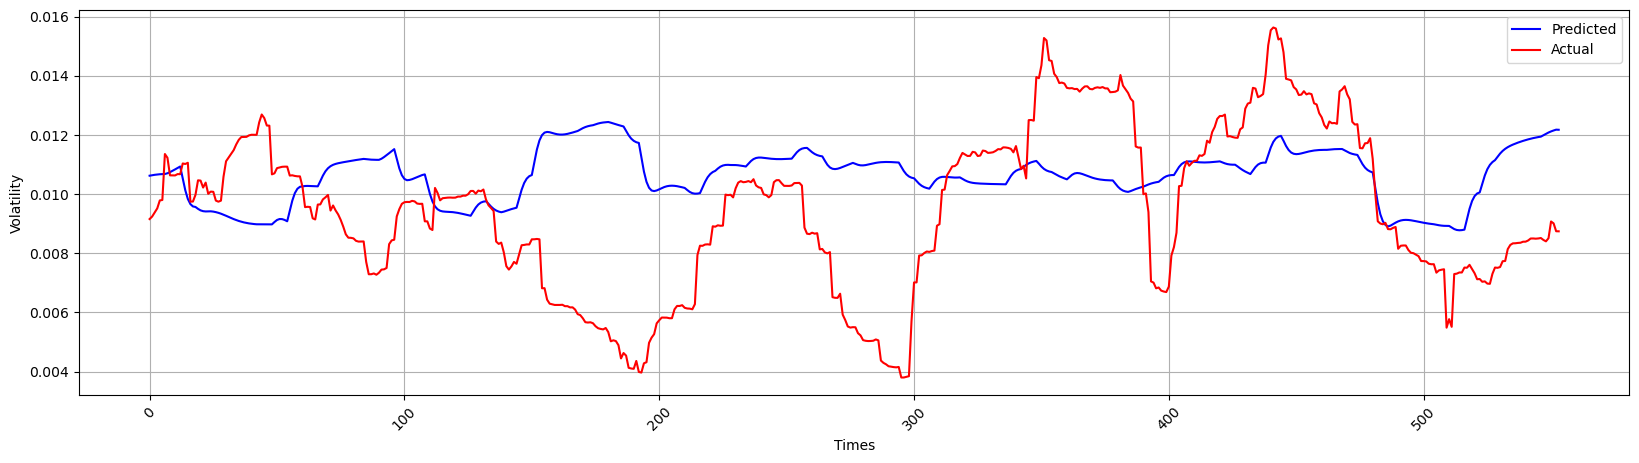

In [17]:
# 6/13 수정중
# HMAE 코드 수정
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import random

# 데이터셋 준비
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# 경제지표 모두 추가
X_garch = df[['KOSPI200_vol','CBOE_VIX_vol','USD_KRW_vol']].values 

# # 경제지표 다 뺌
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility']].values 

# #USD_KRW_vol만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','USD_KRW_vol']].values 

# #'CBOE_VIX_vol'만 추가
# X_garch = df[['predicted_volatility', 'CBOE_VIX_vol']].values 

# #KOSPI200_vol만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','KOSPI200_vol']].values

# #USD + CBOE 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','CBOE_VIX_vol']].values 

# #USD + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','KOSPI200_vol']].values 

# #CEOB + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol','KOSPI200_vol']].values 

y = df['historical_volatility'].values

def dataset_split(x_set, y_set):
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')
    train_x = x_set[:train_end + 1]
    train_y = y_set[:train_end + 1]
    valid_x = x_set[train_end + 1:valid_end + 1]
    valid_y = y_set[train_end + 1:valid_end + 1]
    test_x = x_set[valid_end + 1:]
    test_y = y_set[valid_end + 1:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler_x.fit_transform(train_X_garch)
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch = Y_train
valid_y_garch = Y_valid
test_y_garch = Y_test

train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)


# HMAE 계산 함수
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(tf.cast(y_true - y_pred, tf.float32), axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance + tf.keras.backend.epsilon()))
        return hmae

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)

# def build_model():
#     inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
#     y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
#     y = tf.keras.layers.LSTM(units=500)(y)
#     y = tf.keras.layers.Dense(1)(y)

#     model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

#     model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
#                   loss=tf.keras.losses.MeanSquaredError(),
#                   metrics=[tf.keras.metrics.RootMeanSquaredError()])
#     return model

def build_model():

    inputLSTM_GARCH_EGARCH = Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    x = LSTM(units=200, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    x = Dropout(0.2)(x)
    x = LSTM(units=200)(x)
    x = Dropout(0.2)(x)
    # x = LSTM(units=100)(x)
    x = Dense(1)(x)
    
    model = Model(inputs=inputLSTM_GARCH_EGARCH, outputs=x)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='mean_squared_error',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                    epochs=100,
                    validation_data=(valid_X_garch, valid_y_garch),
                    batch_size=128,
                    callbacks=[stop_early],
                    shuffle=False)


def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    #plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nRMSE: {rmse:.5f}")

    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
    print(f"\nHMAE: {hmae_value.numpy():.5f}")

model_RMSE_plot(history, "LSTM_vol")
printing_out_results_of_a_model(model, test_X_garch, test_y_garch)

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])
    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]
    result_df.to_excel('LSTM_NEW_Edit_11_3.xlsx', index=False)
    return result_df

result_df = result_to_excel(model, test_X_garch, test_y_garch)
plt.figure(figsize=(20, 5))
plt.plot(result_df['Prediction_y'], linestyle='-', color='blue', label='Predicted')
plt.plot(result_df['Actual_y'], linestyle='-', color='red', label='Actual')
plt.xlabel('Times')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_plot_2 = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

plt.figure(figsize=(20, 5)) 
# plt.plot(df_plot_2.index, df_plot_2['predicted_volatility'], linestyle='-', color='blue') 
plt.plot(df_plot_2.index, df_plot_2['garch_vol'], linestyle='-', color='red', label='garch_vol')
# plt.plot(df_plot_2.index, df_plot_2['egarch_vol'], linestyle='-', color='blue', label='egarch_vol')
plt.plot(df_plot_2.index, df_plot_2['historical_volatility'], linestyle='-', color='green', label='historical_volatility')

plt.title('plot volatility') 
plt.xlabel('datetime') 
plt.ylabel('Volatility') 
plt.xticks(rotation=45) 
plt.grid(True) 

# 그래프를 보여줍니다.
plt.show()

# 6

X_train: (6534, 42, 3) Y_train: (6534, 1)
X_test: (554, 42, 3) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 2.5753e-04 - root_mean_squared_error: 0.0157 - val_loss: 8.0150e-05 - val_root_mean_squared_error: 0.0090
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 2.4443e-04 - root_mean_squared_error: 0.0151 - val_loss: 7.0951e-05 - val_root_mean_squared_error: 0.0084
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.8765e-04 - root_mean_squared_error: 0.0135 - val_loss: 4.5718e-05 - val_root_mean_squared_error: 0.0068
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 2.4288e-04 - root_mean_squared_error: 0.0155 - val_loss: 7.7170e-05 - val_root_mean_squared_error: 0.0088
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 1.9705e-04 - root_mean_squared_error: 0.0136 - val_loss: 4.0887e-05 - val_root_mean_squared_error: 0.0064
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 4.9285e-05 - root_mean_squared_error

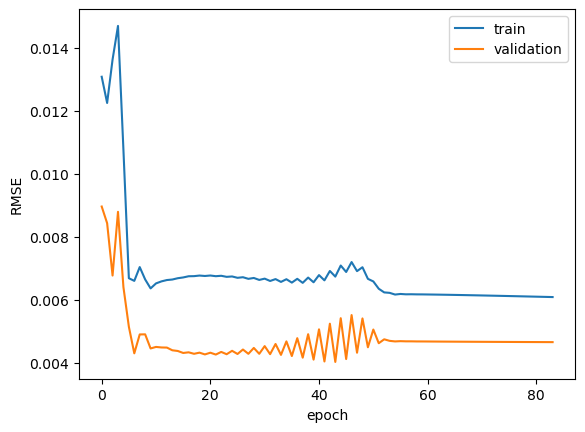

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step

RMSE: 0.00316

HMAE: 0.92279
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step


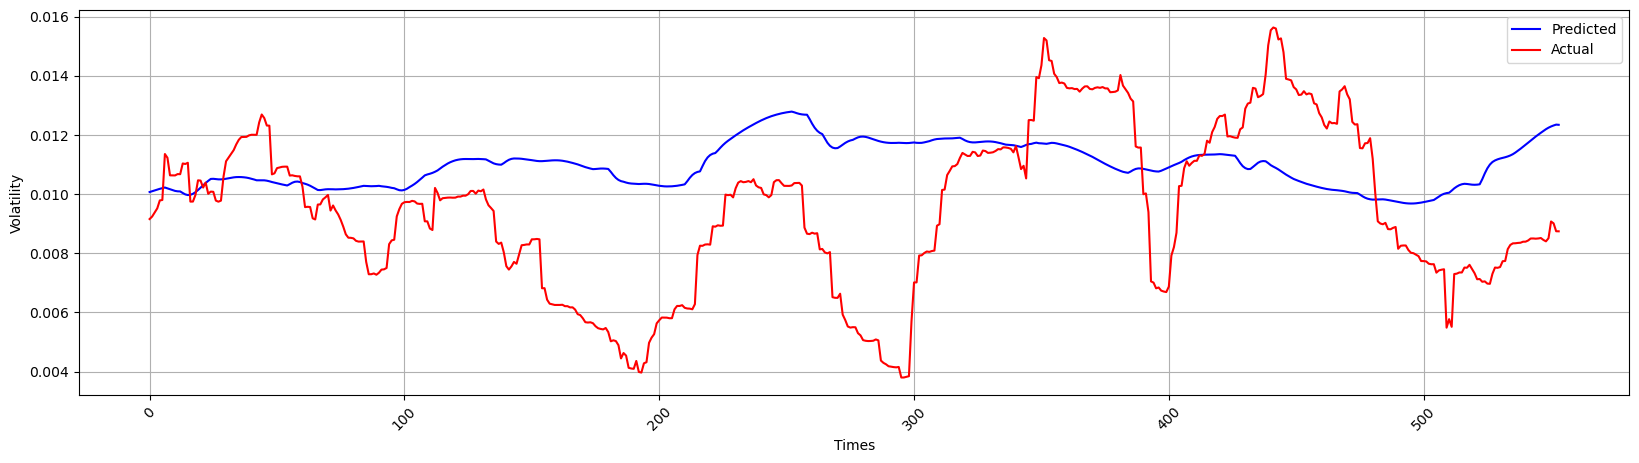

In [1]:
# 6/13 수정중
# HMAE 코드 수정
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import random

# 데이터셋 준비
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# # 경제지표 모두 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','KOSPI200_vol','CBOE_VIX_vol','USD_KRW_vol']].values 

# # 경제지표 다 뺌
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility']].values 

# #USD_KRW_vol만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','USD_KRW_vol']].values 

# #'CBOE_VIX_vol'만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','CBOE_VIX_vol']].values 

# #KOSPI200_vol만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility', 'KOSPI200_vol']].values

#USD + CBOE 조합
X_garch = df[['predicted_volatility','USD_KRW_vol','CBOE_VIX_vol']].values 

# #USD + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','KOSPI200_vol']].values 

# #CEOB + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol','KOSPI200_vol']].values 

y = df['historical_volatility'].values

def dataset_split(x_set, y_set):
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')
    train_x = x_set[:train_end + 1]
    train_y = y_set[:train_end + 1]
    valid_x = x_set[train_end + 1:valid_end + 1]
    valid_y = y_set[train_end + 1:valid_end + 1]
    test_x = x_set[valid_end + 1:]
    test_y = y_set[valid_end + 1:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler_x.fit_transform(train_X_garch)
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch = Y_train
valid_y_garch = Y_valid
test_y_garch = Y_test

train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)


# HMAE 계산 함수
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(tf.cast(y_true - y_pred, tf.float32), axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance + tf.keras.backend.epsilon()))
        return hmae

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)

def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                    epochs=100,
                    validation_data=(valid_X_garch, valid_y_garch),
                    batch_size=512,
                    callbacks=[stop_early],
                    shuffle=False)


def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    #plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nRMSE: {rmse:.5f}")

    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
    print(f"\nHMAE: {hmae_value.numpy():.5f}")

model_RMSE_plot(history, "LSTM_vol")
printing_out_results_of_a_model(model, test_X_garch, test_y_garch)

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])
    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]
    result_df.to_excel('LSTM_NEW6.xlsx', index=False)
    return result_df

result_df = result_to_excel(model, test_X_garch, test_y_garch)
plt.figure(figsize=(20, 5))
plt.plot(result_df['Prediction_y'], linestyle='-', color='blue', label='Predicted')
plt.plot(result_df['Actual_y'], linestyle='-', color='red', label='Actual')
plt.xlabel('Times')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# 7

X_train: (6534, 42, 3) Y_train: (6534, 1)
X_test: (554, 42, 3) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 2.4184e-04 - root_mean_squared_error: 0.0153 - val_loss: 9.2043e-05 - val_root_mean_squared_error: 0.0096
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 8.4777e-05 - root_mean_squared_error: 0.0091 - val_loss: 5.3548e-05 - val_root_mean_squared_error: 0.0073
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 2.4456e-04 - root_mean_squared_error: 0.0155 - val_loss: 1.1691e-04 - val_root_mean_squared_error: 0.0108
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 4.9776e-04 - root_mean_squared_error: 0.0220 - val_loss: 6.0155e-05 - val_root_mean_squared_error: 0.0078
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 1.5929e-04 - root_mean_squared_error: 0.0126 - val_loss: 3.4820e-05 - val_root_mean_squared_error: 0.0059
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 1.7238e-04 - root_mean_squared_error

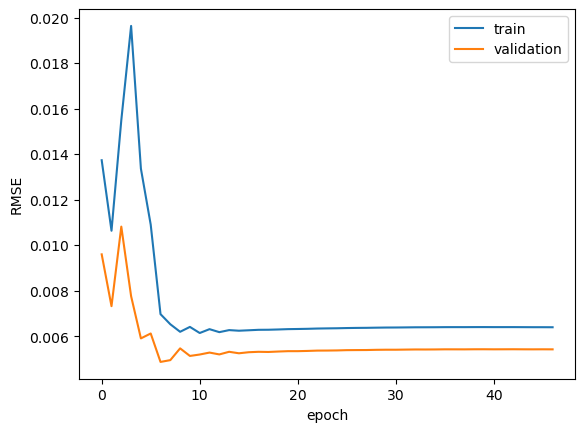

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step

RMSE: 0.00438

HMAE: 1.23008
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step


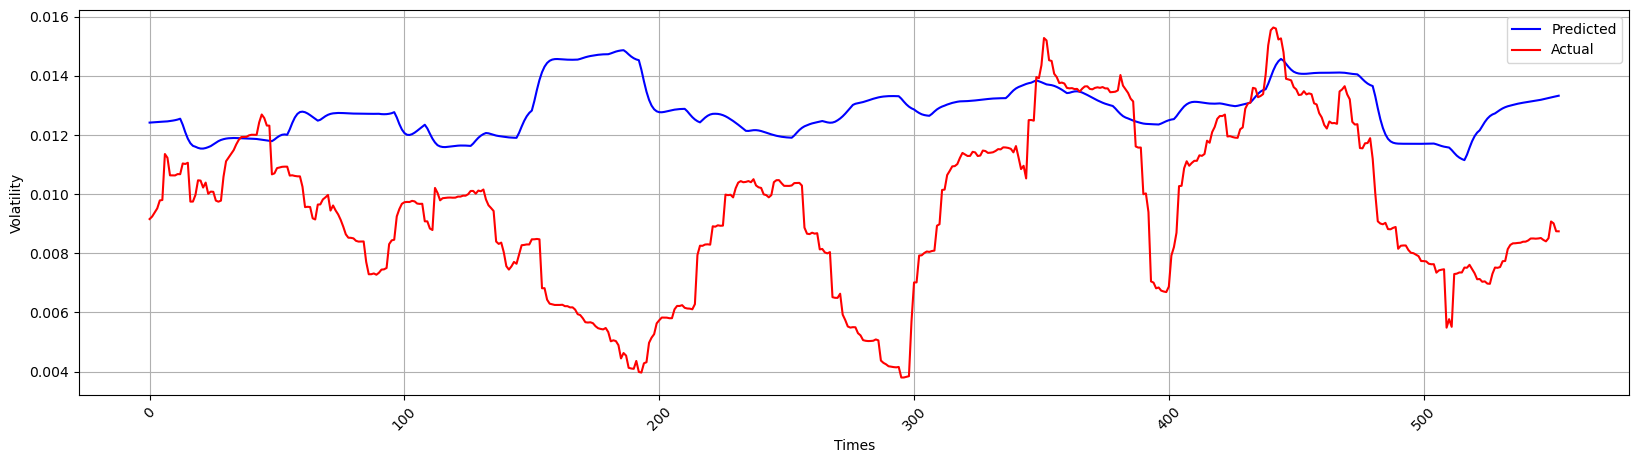

In [2]:
# 6/13 수정중
# HMAE 코드 수정
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import random

# 데이터셋 준비
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# # 경제지표 모두 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','KOSPI200_vol','CBOE_VIX_vol','USD_KRW_vol']].values 

# # 경제지표 다 뺌
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility']].values 

# #USD_KRW_vol만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','USD_KRW_vol']].values 

# #'CBOE_VIX_vol'만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','CBOE_VIX_vol']].values 

# #KOSPI200_vol만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility', 'KOSPI200_vol']].values

# #USD + CBOE 조합
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','USD_KRW_vol','CBOE_VIX_vol']].values 

#USD + KOSPI 조합
X_garch = df[['predicted_volatility', 'USD_KRW_vol', 'KOSPI200_vol']].values 

# #CEOB + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol','KOSPI200_vol']].values 

y = df['historical_volatility'].values

def dataset_split(x_set, y_set):
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')
    train_x = x_set[:train_end + 1]
    train_y = y_set[:train_end + 1]
    valid_x = x_set[train_end + 1:valid_end + 1]
    valid_y = y_set[train_end + 1:valid_end + 1]
    test_x = x_set[valid_end + 1:]
    test_y = y_set[valid_end + 1:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler_x.fit_transform(train_X_garch)
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch = Y_train
valid_y_garch = Y_valid
test_y_garch = Y_test

train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)


# HMAE 계산 함수
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(tf.cast(y_true - y_pred, tf.float32), axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance + tf.keras.backend.epsilon()))
        return hmae

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)

def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                    epochs=100,
                    validation_data=(valid_X_garch, valid_y_garch),
                    batch_size=512,
                    callbacks=[stop_early],
                    shuffle=False)


def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    #plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nRMSE: {rmse:.5f}")

    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
    print(f"\nHMAE: {hmae_value.numpy():.5f}")

model_RMSE_plot(history, "LSTM_vol")
printing_out_results_of_a_model(model, test_X_garch, test_y_garch)

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])
    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]
    result_df.to_excel('LSTM_NEW7.xlsx', index=False)
    return result_df

result_df = result_to_excel(model, test_X_garch, test_y_garch)
plt.figure(figsize=(20, 5))
plt.plot(result_df['Prediction_y'], linestyle='-', color='blue', label='Predicted')
plt.plot(result_df['Actual_y'], linestyle='-', color='red', label='Actual')
plt.xlabel('Times')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# 8

X_train: (6534, 42, 3) Y_train: (6534, 1)
X_test: (554, 42, 3) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 2.1750e-04 - root_mean_squared_error: 0.0145 - val_loss: 1.4296e-04 - val_root_mean_squared_error: 0.0120
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 3.7475e-04 - root_mean_squared_error: 0.0185 - val_loss: 3.6092e-05 - val_root_mean_squared_error: 0.0060
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.0337e-04 - root_mean_squared_error: 0.0102 - val_loss: 2.5152e-05 - val_root_mean_squared_error: 0.0050
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.6974e-04 - root_mean_squared_error: 0.0129 - val_loss: 1.0829e-04 - val_root_mean_squared_error: 0.0104
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.7660e-04 - root_mean_squared_error: 0.0130 - val_loss: 4.3487e-05 - val_root_mean_squared_error: 0.0066
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 7.1452e-05 - root_mean_squared_error

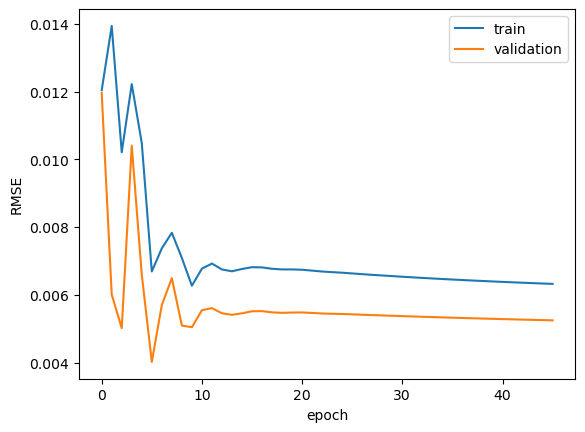

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step

RMSE: 0.00342

HMAE: 0.97488
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step


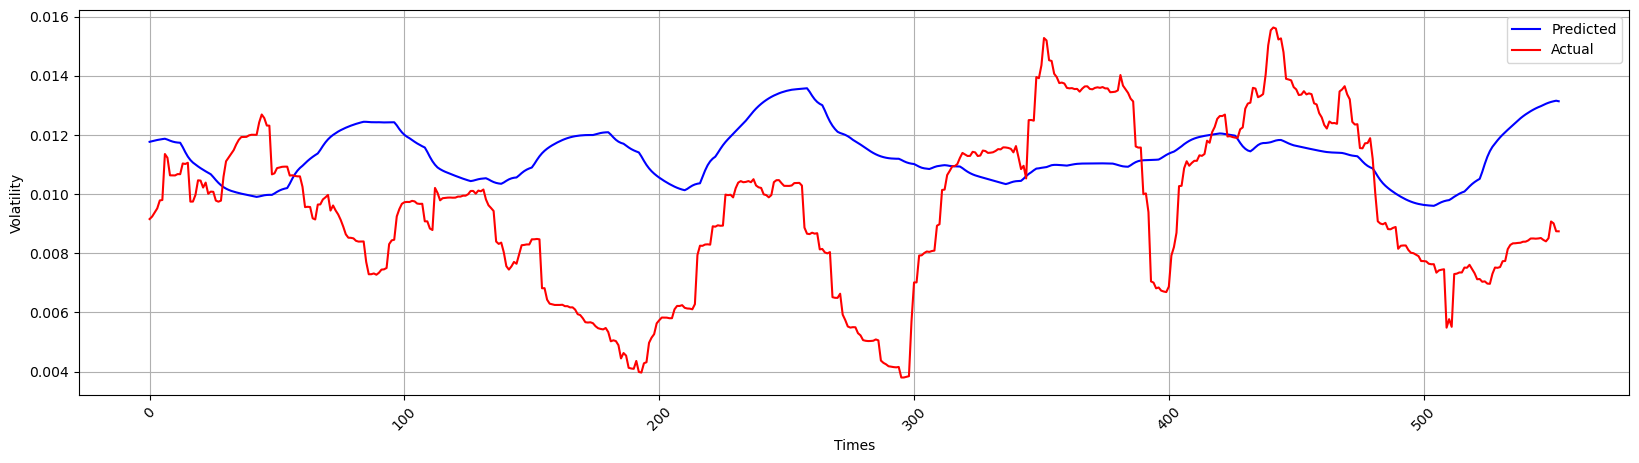

In [3]:
# 6/13 수정중
# HMAE 코드 수정
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import random

# 데이터셋 준비
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# # 경제지표 모두 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','KOSPI200_vol','CBOE_VIX_vol','USD_KRW_vol']].values 

# # 경제지표 다 뺌
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility']].values 

# #USD_KRW_vol만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','USD_KRW_vol']].values 

# #'CBOE_VIX_vol'만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','CBOE_VIX_vol']].values 

# #KOSPI200_vol만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility', 'KOSPI200_vol']].values

# #USD + CBOE 조합
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','USD_KRW_vol','CBOE_VIX_vol']].values 

# #USD + KOSPI 조합
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','USD_KRW_vol','KOSPI200_vol']].values 

#CEOB + KOSPI 조합
X_garch = df[['predicted_volatility', 'CBOE_VIX_vol', 'KOSPI200_vol']].values 

y = df['historical_volatility'].values

def dataset_split(x_set, y_set):
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')
    train_x = x_set[:train_end + 1]
    train_y = y_set[:train_end + 1]
    valid_x = x_set[train_end + 1:valid_end + 1]
    valid_y = y_set[train_end + 1:valid_end + 1]
    test_x = x_set[valid_end + 1:]
    test_y = y_set[valid_end + 1:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler_x.fit_transform(train_X_garch)
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch = Y_train
valid_y_garch = Y_valid
test_y_garch = Y_test

train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)


# HMAE 계산 함수
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(tf.cast(y_true - y_pred, tf.float32), axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance + tf.keras.backend.epsilon()))
        return hmae

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)

def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                    epochs=100,
                    validation_data=(valid_X_garch, valid_y_garch),
                    batch_size=512,
                    callbacks=[stop_early],
                    shuffle=False)


def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    #plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nRMSE: {rmse:.5f}")

    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
    print(f"\nHMAE: {hmae_value.numpy():.5f}")

model_RMSE_plot(history, "LSTM_vol")
printing_out_results_of_a_model(model, test_X_garch, test_y_garch)

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])
    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]
    result_df.to_excel('LSTM_NEW8.xlsx', index=False)
    return result_df

result_df = result_to_excel(model, test_X_garch, test_y_garch)
plt.figure(figsize=(20, 5))
plt.plot(result_df['Prediction_y'], linestyle='-', color='blue', label='Predicted')
plt.plot(result_df['Actual_y'], linestyle='-', color='red', label='Actual')
plt.xlabel('Times')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()